In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## 3. Data Loading

In [2]:
df = pd.read_excel('Dataset_CreditScoring.xlsx')

In [3]:
df_copy = df.copy()

In [4]:
df.head()

,TARGET,ID,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,...,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
0,1.0,582,3.0,3.0,0.0,4.0,0.0,5.0,117.0,27.0,...,3.0,0.9179,0.2083,2.0,3.0,7.0,0.2083,4.0,4.0,0.0000
1,1.0,662,15.0,9.0,0.0,3.0,1.0,3.0,14.0,14.0,...,1.0,0.8000,0.0000,0.0,0.0,0.0,1.0000,12.0,0.0,1.0000
2,1.0,805,0.0,0.0,0.0,1.0,5.0,1.0,354.0,7.0,...,5.0,0.3552,0.6538,0.0,1.0,1.0,0.7308,1.0,1.0,0.5263
3,1.0,1175,8.0,5.0,0.0,6.0,1.0,10.0,16.0,4.0,...,3.0,0.9127,0.2500,1.0,1.0,1.0,0.7500,7.0,1.0,1.3333
4,1.0,1373,3.0,1.0,0.0,9.0,0.0,8.0,130.0,52.0,...,1.0,1.2511,0.0000,0.0,1.0,4.0,0.1429,3.0,1.0,0.0000


## 4. Exploratory Data Analysis (EDA)

In [7]:
# check detail and info of data
desc = df.describe().T
desc['miss_values'] = df.isnull().sum()
desc['Unique_values'] = [df[i].nunique() for i in df.columns]
desc['type'] =  df.dtypes
desc

,count,mean,std,min,25%,50%,75%,max,miss_values,Unique_values,type
TARGET,3000.0,0.166667,0.372740,0.0,0.0000,0.00000,0.00000,1.0000,0,2,float64
ID,3000.0,62922.683667,37203.691912,66.0,30376.5000,62872.50000,96156.50000,126503.0000,0,3000,int64
DerogCnt,3000.0,1.430000,2.731469,0.0,0.0000,0.00000,2.00000,51.0000,0,26,float64
CollectCnt,3000.0,0.857000,2.161352,0.0,0.0000,0.00000,1.00000,50.0000,0,24,float64
BanruptcyInd,3000.0,0.153333,0.360369,0.0,0.0000,0.00000,0.00000,1.0000,0,2,float64
InqCnt06,3000.0,3.108333,3.479171,0.0,1.0000,2.00000,4.00000,40.0000,0,30,float64
InqTimeLast,2812.0,3.108108,4.637831,0.0,1.0000,1.00000,3.00000,24.0000,188,25,float64
InqFinanceCnt24,3000.0,3.555000,4.477536,0.0,1.0000,2.00000,5.00000,48.0000,0,37,float64
TLTimeFirst,3000.0,170.113667,92.813700,6.0,106.0000,151.00000,227.00000,933.0000,0,419,float64
TLTimeLast,3000.0,11.873667,16.321412,0.0,4.0000,7.00000,13.00000,342.0000,0,97,float64


In [8]:
df.duplicated().sum()

0

In [9]:
df.shape

(3000, 30)

from the information above we can notice some valuable information about the dataset
* dataset have 3000 rows and 30 columns columns in total
* all columns are numeric types
* there are few of missing value on some columns
* there is no duplicated value
* there are some columns that contain high cardinality values such as ID, TLSum, TLMaxSum, TLBalHCPct
* based on statistic information on TARGET columns, we can say that the dataset is quite imbalance

**TARGET**

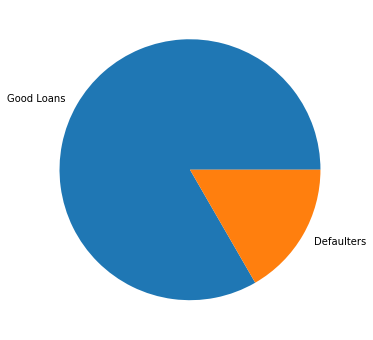

In [57]:
df.TARGET.map({0.0:'Good Loans', 1.0:'Defaulters'}).value_counts().plot.pie(figsize=(6,6), ylabel='');

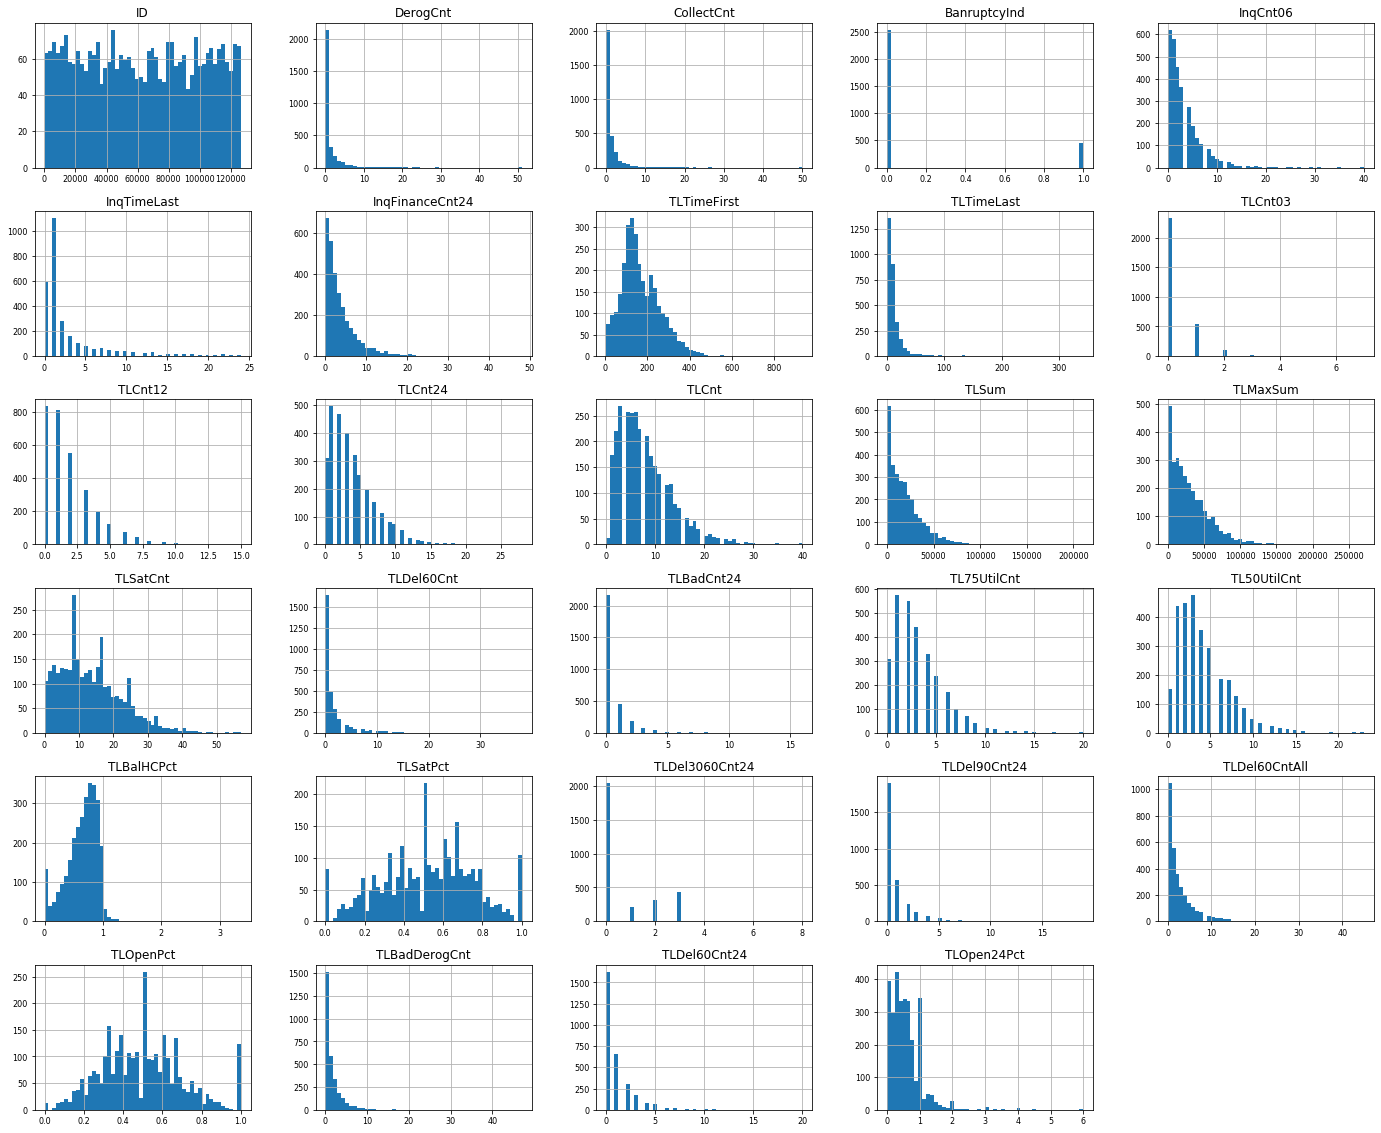

In [63]:
df.loc[:, df.columns!='TARGET'].hist(figsize=(24, 20), bins=50, xlabelsize=8, ylabelsize=8);

**Correlated Features**

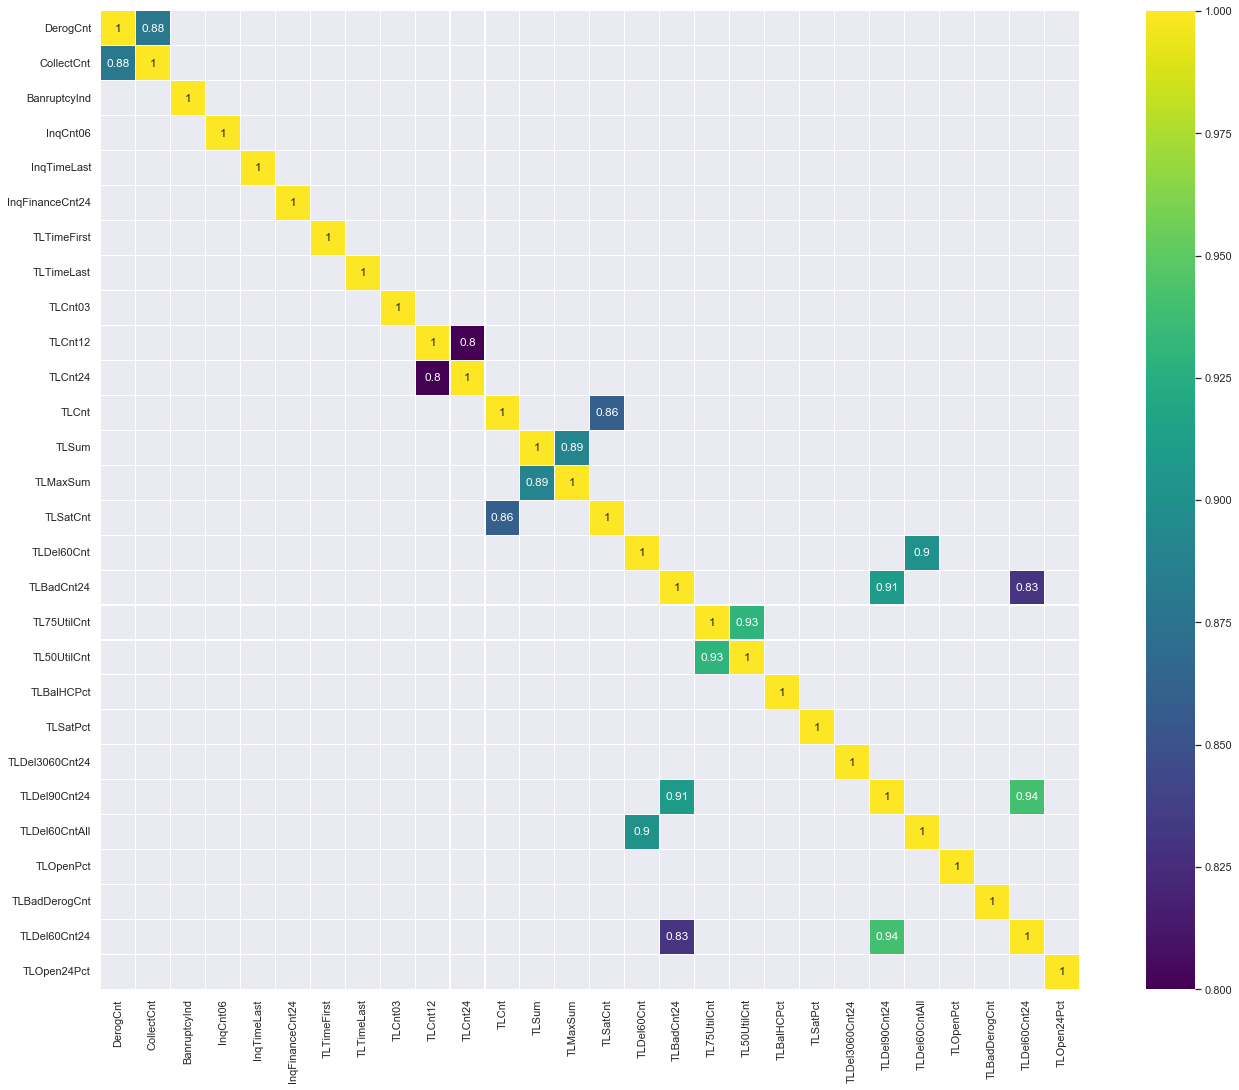

In [174]:
corr = df.drop(columns=['TARGET', 'ID']).corr().round(2)
plt.figure(figsize=(24,18));
sns.heatmap(corr[(corr >= 0.8) | (corr <= -0.8)], annot=True, 
            cmap='viridis', square=True, linewidths=0.1);

based on heatmap above, we can see that a lot of features seems to be correlated between each other. lets explore some of them.
* collumn CollectCnt and DerogCnt has strong postive correlation. its normal considering the more you make collections the higher chance derogatory item is considered to be negative, and typically indicates a serious delinquency or late payments.
* collumn TLCnt12 and TLCnt24 has strong postive correlation.
* collumn TLSum and TLMaxSum has strong postive correlation.
* collumn TLCnt and TLSatCnt has strong postive correlation.
* collumn TLDel60Cnt and TLDel60CntAll has strong postive correlation.
* collumn TLBadCnt24 has strong postive correlation with collumns TLDel90Cnt24 and TLDel60Cnt24.
* collumn TL50UtilCnt and TL75UtilCnt has strong postive correlation.
* collumn TLDel60Cnt and TLDel60CntAll has strong postive correlation.

## 5. Data Preprocessing

In [120]:
X = df.drop(columns='TARGET')
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Outliers Handling

In [121]:
def box_plot(data, ncols, nrows):
  fig, axe = plt.subplots(ncols,nrows, figsize=(ncols*5,nrows*3));
  axes = axe.flatten();
  for i,j in enumerate(data):
    sns.boxplot(data[j], ax=axes[i]);
    axes[i].set_title(j);
    axes[i].set_xlabel('');
  plt.subplots_adjust(hspace=0.4);
  plt.show();

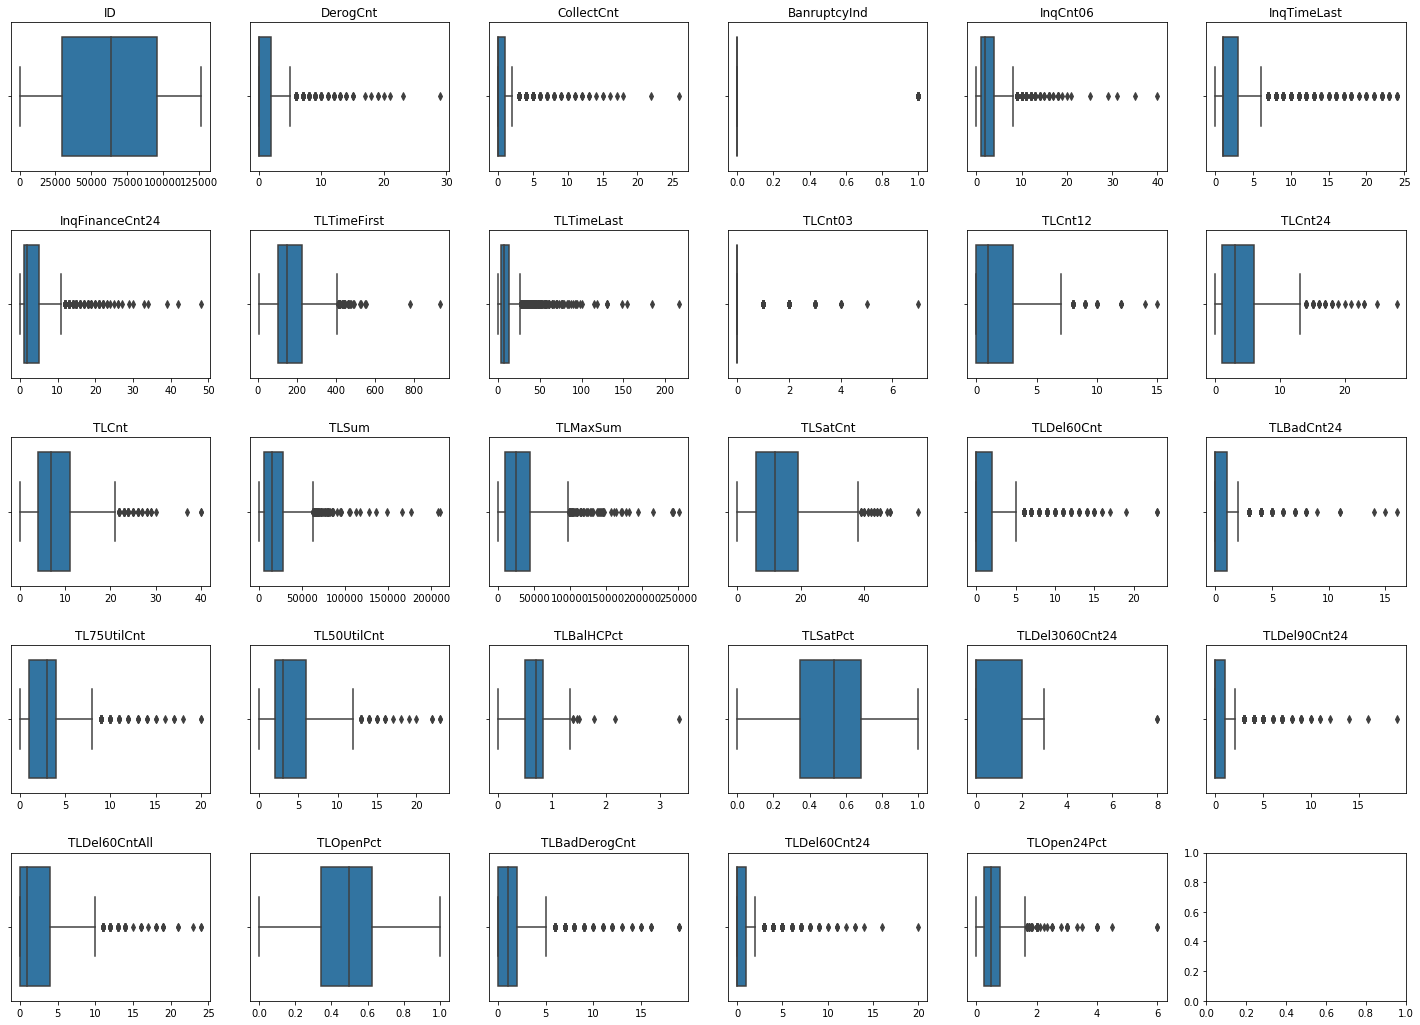

In [122]:
box_plot(X_train, ncols=5, nrows=6)

there are really lot of outliers in most of collumns. so to make work lot easier, we are going to drop the collumn instead. those collumn would be the one which has high correlation to other collumns. so lets find those collumn first and then drop one of them later.

In [123]:
corr = df.corr().round(2)
drop_feat = ['ID']
for i in range(len(corr)):
    for j in range(i):
        if (corr.iloc[i][j] >=0.7 or corr.iloc[i][j] <=-0.7)  and i != j:
            drop_feat.append(corr.columns[i])
            break
print(drop_feat)

['ID', 'CollectCnt', 'InqFinanceCnt24', 'TLCnt24', 'TLMaxSum', 'TLSatCnt', 'TL50UtilCnt', 'TLDel90Cnt24', 'TLDel60CntAll', 'TLBadDerogCnt', 'TLDel60Cnt24']


the collumn that we going to drop listed below,

['ID', 'CollectCnt', 'InqFinanceCnt24', 'TLCnt24', 'TLMaxSum', 'TLSatCnt', 'TL50UtilCnt', 'TLDel90Cnt24', 'TLDel60CntAll', 'TLBadDerogCnt', 'TLDel60Cnt24']

to make everything looks organize and clean lets make a pipeline for the collumn dropper

In [124]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [125]:
drop_columns = make_pipeline(columnDropperTransformer(drop_feat))
X_train = drop_columns.fit_transform(X_train)

lets check the precentage of outliers on each collumns.

In [126]:
def outliers_percentage(datas, m):
    q3 = datas.quantile(0.75)
    q1 = datas.quantile(0.25)
    bb = q1 - (q3-q1)*m #batas bawah
    ba = q3 + (q3-q1)*m #batas atas
    outliers =  np.sum((datas < bb) |(datas > ba))
    tots = datas.count()
    return ((outliers/tots)*100).round(2)

In [127]:
for column in X_train.columns:
    datas = X_train[column]
    percent = str(round(outliers_percentage(datas, 1.5), 5))
    print(f'Outliers collumns "{column}": {percent}%')

Outliers collumns "DerogCnt": 5.81%
Outliers collumns "BanruptcyInd": 15.14%
Outliers collumns "InqCnt06": 7.1%
Outliers collumns "InqTimeLast": 15.67%
Outliers collumns "TLTimeFirst": 1.67%
Outliers collumns "TLTimeLast": 8.76%
Outliers collumns "TLCnt03": 21.86%
Outliers collumns "TLCnt12": 1.9%
Outliers collumns "TLCnt": 2.48%
Outliers collumns "TLSum": 3.42%
Outliers collumns "TLDel60Cnt": 7.76%
Outliers collumns "TLBadCnt24": 6.05%
Outliers collumns "TL75UtilCnt": 3.55%
Outliers collumns "TLBalHCPct": 0.34%
Outliers collumns "TLSatPct": 0.0%
Outliers collumns "TLDel3060Cnt24": 0.1%
Outliers collumns "TLOpenPct": 0.0%
Outliers collumns "TLOpen24Pct": 2.81%


so heres our remaining collumn with listed outliers percentage on each. heres some decision i make regarding to handle outliers
* its seems like some collumns have lot of outliers for instance collumn TLCnt03 with outliers percentage 21.85 %. with this lot of outliers we cannot simply trim or winsorize them. we need to look further because its mean that there’s something interesting going on with the data. so for collumns that contain up to 15 % outliers we are not going to handle them rather just leave them the way it is.
* since we face with small amount of dataset we dont have any plan to drop any outliers or missing value. so for collumns that contain less than 15 % outliers we are going to treat them as missing value then impute them with predicted values using KNN imputer.



In [128]:
col_less_15 = ["DerogCnt", "InqCnt06", "TLTimeFirst", "TLTimeLast", 
               "TLCnt12", "TLCnt", "TLSum", "TLDel60Cnt", "TLBadCnt24",
               "TL75UtilCnt", "TLBalHCPct", "TLSatPct", "TLDel3060Cnt24",
               "TLOpenPct", "TLOpen24Pct"]

In [129]:
for i in col_less_15:
    datas = X_train[i]
    
    q3 = datas.quantile(0.75)
    q1 = datas.quantile(0.25)
    bb = q1 - (q3-q1)*1.5 #batas bawah
    ba = q3 + (q3-q1)*1.5 #batas atas
 
    outliers = ((datas < bb) |(datas > ba))
    X_train[i].loc[outliers] = np.nan;
    
X_train.isnull().sum()

DerogCnt          122
BanruptcyInd        0
InqCnt06          149
InqTimeLast       128
TLTimeFirst        35
TLTimeLast        184
TLCnt03             0
TLCnt12            40
TLCnt              53
TLSum              97
TLDel60Cnt        163
TLBadCnt24        127
TL75UtilCnt       141
TLBalHCPct         34
TLSatPct            2
TLDel3060Cnt24      2
TLOpenPct           1
TLOpen24Pct        60
dtype: int64

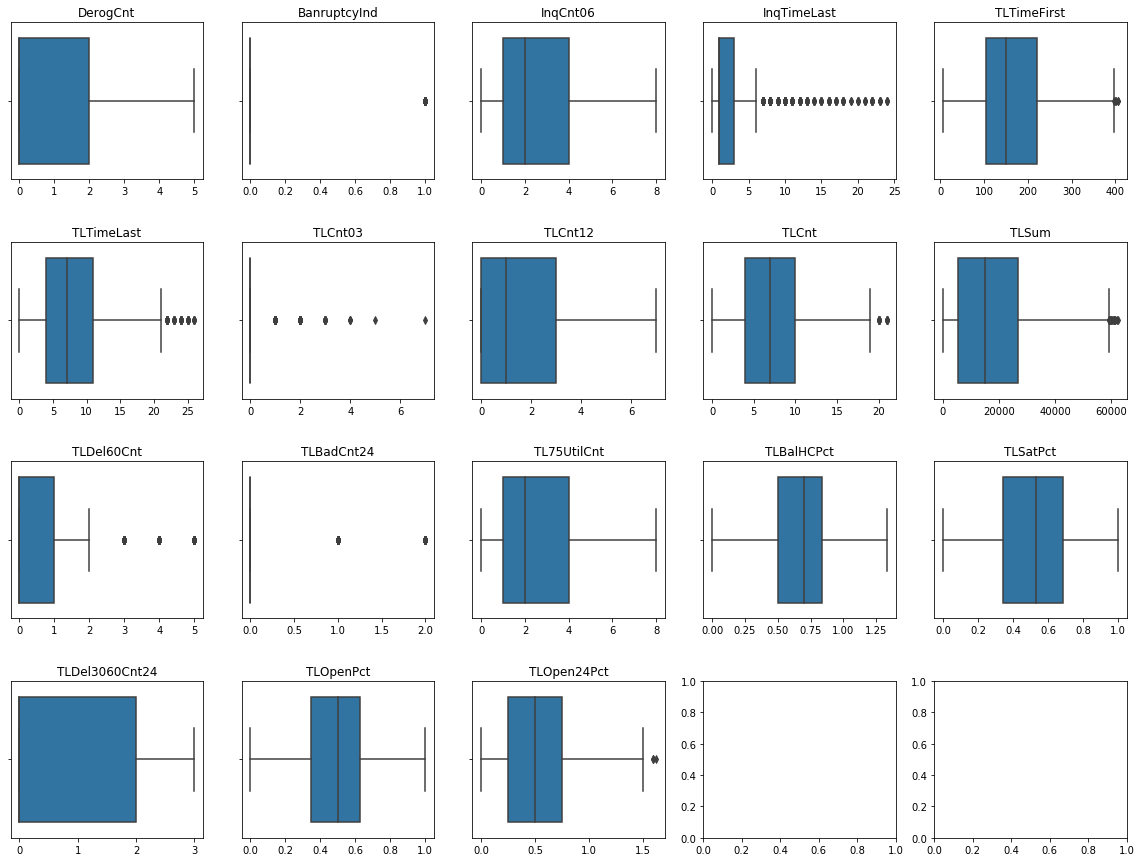

In [21]:
box_plot(X_train, ncols=4, nrows=5)

### Handling Missing Values

In [130]:
imputer = KNNImputer()
X_train2 = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train2, columns=X_train.columns)
X_train.isnull().sum()

DerogCnt          0
BanruptcyInd      0
InqCnt06          0
InqTimeLast       0
TLTimeFirst       0
TLTimeLast        0
TLCnt03           0
TLCnt12           0
TLCnt             0
TLSum             0
TLDel60Cnt        0
TLBadCnt24        0
TL75UtilCnt       0
TLBalHCPct        0
TLSatPct          0
TLDel3060Cnt24    0
TLOpenPct         0
TLOpen24Pct       0
dtype: int64

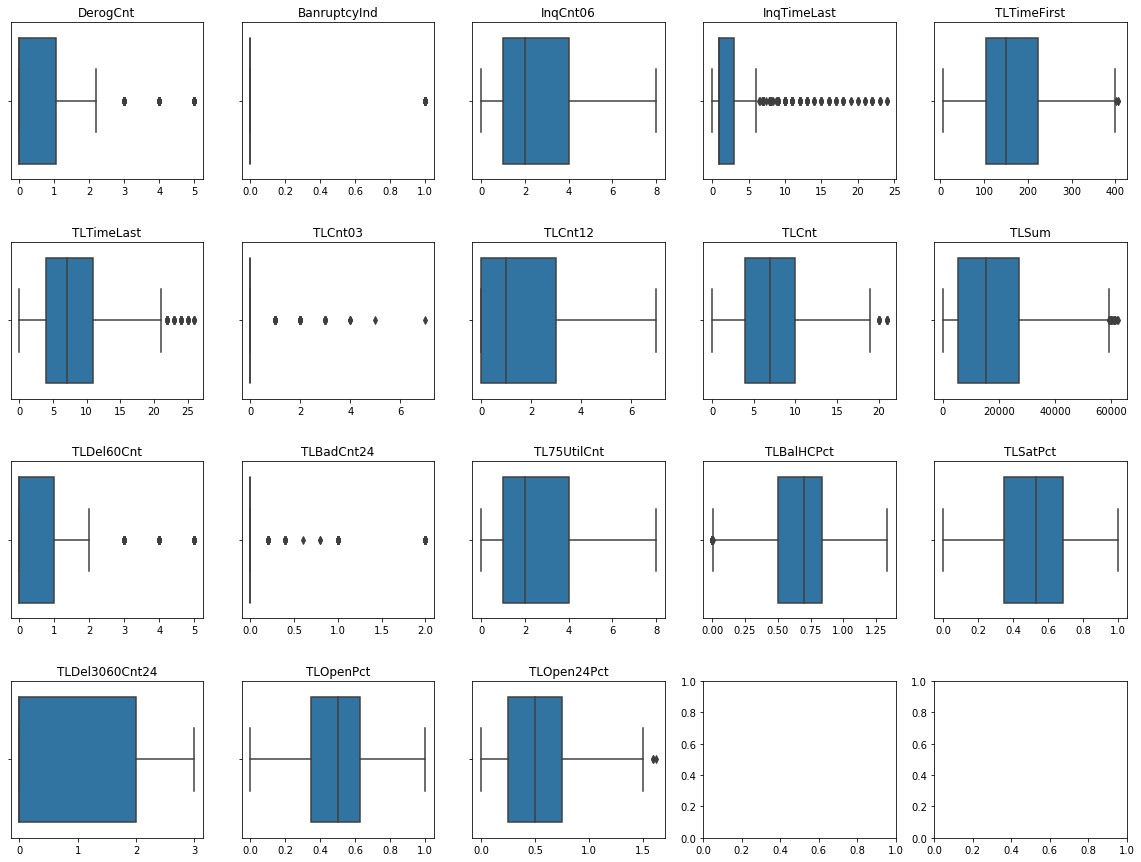

In [131]:
box_plot(X_train, ncols=4, nrows=5)

### Handling Imbalance & Scalling

In [132]:
smt = SMOTETomek()
X_train, y_train = smt.fit_resample(X_train, y_train)

In [133]:
y_train.value_counts()

0.0    1524
1.0    1524
Name: TARGET, dtype: int64

In [134]:
#scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [135]:
data_pipeline = make_pipeline(drop_columns, imputer, scaler)

In [136]:
X_test = data_pipeline.transform(X_test)

In [200]:
# drop_feat = ['ID', 'DerogCnt', 'TLCnt24', 'TLMaxSum', 'TLSatCnt', 'TL75UtilCnt', 'TLDel60CntAll', 'TLBadCnt24']

## 6. Model Definition

In [137]:
model_rfc = RandomForestClassifier(random_state=0)
model_ada = AdaBoostClassifier(random_state=0)

In [138]:
model_ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [139]:
model_rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [140]:
y_pred_test_ada = model_ada.predict(X_test)
y_pred_test_rfc = model_rfc.predict(X_test)

In [150]:
print(classification_report(y_test, y_pred_test_ada))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89       750
         1.0       0.37      0.25      0.30       150

    accuracy                           0.80       900
   macro avg       0.62      0.58      0.59       900
weighted avg       0.78      0.80      0.79       900



In [142]:
print(classification_report(y_test, y_pred_test_rfc))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       750
         1.0       0.43      0.24      0.31       150

    accuracy                           0.82       900
   macro avg       0.64      0.59      0.60       900
weighted avg       0.79      0.82      0.80       900



In [148]:
y_pred_train_ada = model_ada.predict(X_train)

In [149]:
print(classification_report(y_train, y_pred_train_ada))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88      1524
         1.0       0.88      0.86      0.87      1524

    accuracy                           0.87      3048
   macro avg       0.87      0.87      0.87      3048
weighted avg       0.87      0.87      0.87      3048



## 7. Model Training

## 8. Model Evaluation